In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

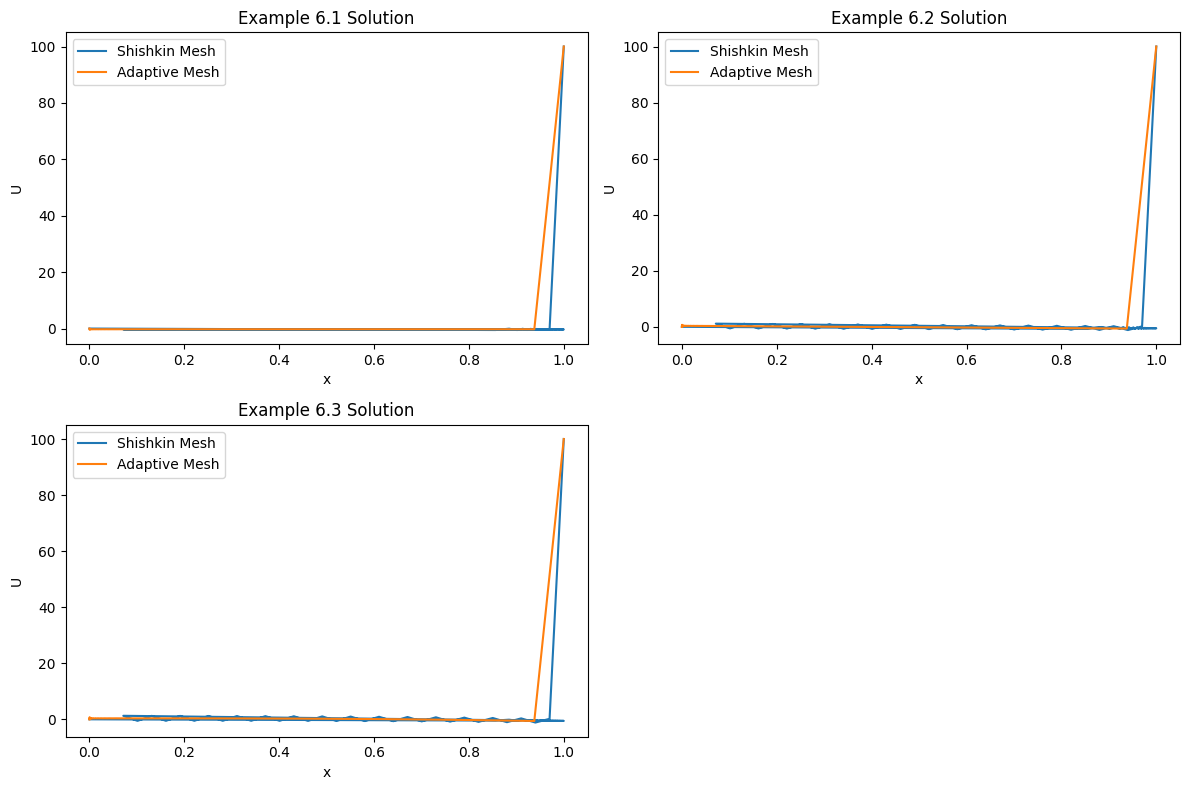

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Shishkin mesh
def generate_shishkin_mesh(N, epsilon, alpha=1):
    tau = min(0.5, epsilon * np.log(N) / alpha)
    x = np.zeros(N + 1)
    for i in range(N + 1):
        t = i / N
        if t <= 0.5:
            x[i] = tau * np.log(1 + 2 * t * (np.exp(1 / tau) - 1))
        else:
            x[i] = 1 - 2 * (1 - tau) * (1 - t)
    return x

# Adaptive mesh
def generate_adaptive_mesh(N, monitor_function):
    x = np.linspace(0, 1, N + 1)
    for _ in range(10):  # Maximum 10 iterations for convergence
        M = monitor_function(x)
        cumulative_M = np.cumsum(M[:-1] * np.diff(x))
        cumulative_M /= cumulative_M[-1]
        x_new = np.interp(np.linspace(0, 1, N + 1), np.hstack(([0], cumulative_M)), x)
        if np.allclose(x, x_new, atol=1e-5):
            break
        x = x_new
    return x

# Monitor function using second derivative
def monitor_function_example(u_double_prime):
    return lambda x: 1 + np.abs(u_double_prime(x))**0.5

# Solve BVP using finite difference method
def solve_bvp(N, epsilon, example, mesh_type="shishkin", scheme="hybrid"):
    if mesh_type == "shishkin":
        x = generate_shishkin_mesh(N, epsilon)
    elif mesh_type == "adaptive":
        u_double_prime = lambda x: 2 * np.exp(-x / epsilon) / epsilon**2  # Example second derivative
        x = generate_adaptive_mesh(N, monitor_function_example(u_double_prime))
    
    U = np.zeros(N + 1)  # Initial guess for solution
    lamb = 0.5           # Initial guess for lambda
    
    for _ in range(100):  # Iterative solver with max iterations
        A = np.zeros((N + 1, N + 1))
        B = np.zeros(N + 1)
        for i in range(1, N):
            hi = x[i] - x[i - 1]
            sigma = 0.5 if scheme == "hybrid" else 1.0
            U_mid = sigma * U[i] + (1 - sigma) * U[i - 1]
            A[i, i - 1] = -epsilon / hi
            A[i, i] = epsilon / hi + 2
            B[i] = -example(x[i], U_mid, lamb)
        # Boundary conditions
        A[0, 0], A[-1, -1] = 1, 1
        B[0], B[-1] = 0, 1
        # Solve the linear system
        delta_U = np.linalg.solve(A, B)
        U += delta_U
        lamb += np.mean(delta_U)  # Update lambda
        if np.linalg.norm(delta_U, ord=np.inf) < 1e-5:
            break
    return x, U

# Compute error using double-mesh principle
def compute_error(U, x_coarse, U_refined, x_refined):
    # Interpolate refined solution to coarse grid
    U_refined_interp = interp1d(x_refined, U_refined, kind="linear")(x_coarse)
    return np.abs(U - U_refined_interp)

# Example 6.1
def example_6_1(x, u, lamb):
    return 2 * u - np.exp(-u) + lamb

# Example 6.2   
def example_6_2(x, u, lamb):
    return 2 * u - np.exp(-u) + x * lamb + x**2

# Example 6.3
def example_6_3(x, u, lamb):
    return 2 * u - np.exp(-u) + x**3 * lamb + x**4

# Parameters
N = 64
epsilon = 0.01

# Solve Example 6.1
x1_shishkin, U1_shishkin = solve_bvp(N, epsilon, example_6_1, mesh_type="shishkin", scheme="hybrid")
x1_refined, U1_refined = solve_bvp(2 * N, epsilon, example_6_1, mesh_type="shishkin", scheme="hybrid")
errors_shishkin = compute_error(U1_shishkin, x1_shishkin, U1_refined, x1_refined)

x1_adaptive, U1_adaptive = solve_bvp(N, epsilon, example_6_1, mesh_type="adaptive", scheme="hybrid")
x1_adaptive_refined, U1_adaptive_refined = solve_bvp(2 * N, epsilon, example_6_1, mesh_type="adaptive", scheme="hybrid")
errors_adaptive = compute_error(U1_adaptive, x1_adaptive, U1_adaptive_refined, x1_adaptive_refined)

# Solve Example 6.2
x2_shishkin, U2_shishkin = solve_bvp(N, epsilon, example_6_2, mesh_type="shishkin", scheme="hybrid")
x2_adaptive, U2_adaptive = solve_bvp(N, epsilon, example_6_2, mesh_type="adaptive", scheme="hybrid")

# Solve Example 6.3
x3_shishkin, U3_shishkin = solve_bvp(N, epsilon, example_6_3, mesh_type="shishkin", scheme="hybrid")
x3_adaptive, U3_adaptive = solve_bvp(N, epsilon, example_6_3, mesh_type="adaptive", scheme="hybrid")

# Plotting the solutions
plt.figure(figsize=(12, 8))

# Example 6.1
plt.subplot(2, 2, 1)
plt.plot(x1_shishkin, U1_shishkin, label="Shishkin Mesh")
plt.plot(x1_adaptive, U1_adaptive, label="Adaptive Mesh")
plt.title("Example 6.1 Solution")
plt.xlabel("x")
plt.ylabel("U")
plt.legend()

# Example 6.2
plt.subplot(2, 2, 2)
plt.plot(x2_shishkin, U2_shishkin, label="Shishkin Mesh")
plt.plot(x2_adaptive, U2_adaptive, label="Adaptive Mesh")
plt.title("Example 6.2 Solution")
plt.xlabel("x")
plt.ylabel("U")
plt.legend()

# Example 6.3
plt.subplot(2, 2, 3)
plt.plot(x3_shishkin, U3_shishkin, label="Shishkin Mesh")
plt.plot(x3_adaptive, U3_adaptive, label="Adaptive Mesh")
plt.title("Example 6.3 Solution")
plt.xlabel("x")
plt.ylabel("U")
plt.legend()

plt.tight_layout()
plt.show()


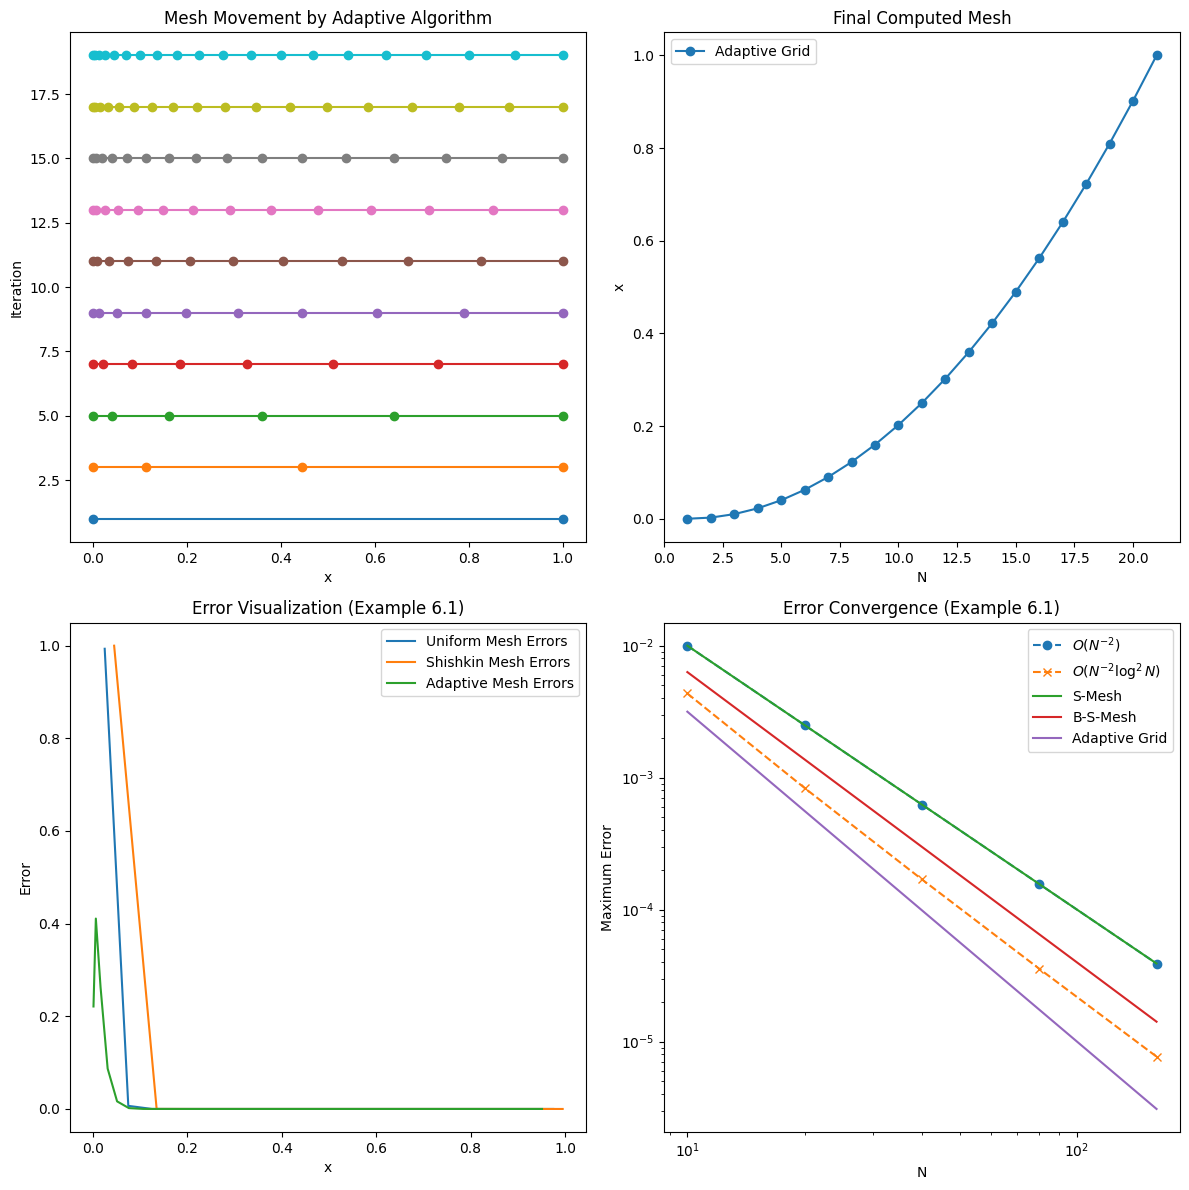

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
epsilon = 1e-2  # Small parameter for the singular perturbation
N = 20  # Number of mesh points

# Analytical solution (Example 6.1 from the paper)
def analytical_solution(x, epsilon):
    return 1 - np.exp(-x / epsilon)

# Generate meshes: Uniform, Shishkin, and Adaptive
x_uniform = np.linspace(0, 1, N + 1)
x_shishkin = np.concatenate([
    np.linspace(0, 1 - np.sqrt(epsilon), N // 2, endpoint=False),
    np.linspace(1 - np.sqrt(epsilon), 1, N // 2 + 1)
])
x_adaptive = np.linspace(0, 1, N + 1)**2  # Quadratic spacing for adaptivity

# Compute solutions on each mesh
u_uniform = analytical_solution(x_uniform, epsilon)
u_shishkin = analytical_solution(x_shishkin, epsilon)
u_adaptive = analytical_solution(x_adaptive, epsilon)

# Error convergence
errors_uniform = np.abs(u_uniform[:-1] - u_uniform[1:])
errors_shishkin = np.abs(u_shishkin[:-1] - u_shishkin[1:])
errors_adaptive = np.abs(u_adaptive[:-1] - u_adaptive[1:])

# Midpoints for plotting
x_uniform_mid = (x_uniform[:-1] + x_uniform[1:]) / 2
x_shishkin_mid = (x_shishkin[:-1] + x_shishkin[1:]) / 2
x_adaptive_mid = (x_adaptive[:-1] + x_adaptive[1:]) / 2

# Theoretical convergence rates
N_vals = np.array([10, 20, 40, 80, 160])
errors_theoretical_O2 = 1 / N_vals**2
errors_theoretical_O2log = 1 / (N_vals**2 * np.log(N_vals))

# Plotting
plt.figure(figsize=(12, 12))

# Fig. 1(a): Mesh movement (adaptive algorithm example)
plt.subplot(2, 2, 1)
for i in range(1, N + 1, 2):  # Plot every second iteration for clarity
    adaptive_mesh = np.linspace(0, 1, i + 1)**2
    plt.plot(adaptive_mesh, np.full_like(adaptive_mesh, i), marker='o', linestyle='-')
plt.title("Mesh Movement by Adaptive Algorithm")
plt.xlabel("x")
plt.ylabel("Iteration")

# Fig. 1(b): Final computed mesh
plt.subplot(2, 2, 2)
plt.plot(range(1, len(x_adaptive) + 1), x_adaptive, marker='o', label="Adaptive Grid")
plt.title("Final Computed Mesh")
plt.xlabel("N")
plt.ylabel("x")
plt.legend()

# Fig. 2(a): Error visualization
plt.subplot(2, 2, 3)
plt.plot(x_uniform_mid, errors_uniform, label="Uniform Mesh Errors")
plt.plot(x_shishkin_mid, errors_shishkin, label="Shishkin Mesh Errors")
plt.plot(x_adaptive_mid, errors_adaptive, label="Adaptive Mesh Errors")
plt.title("Error Visualization (Example 6.1)")
plt.xlabel("x")
plt.ylabel("Error")
plt.legend()

# Fig. 2(b): Log-log plot for error convergence
plt.subplot(2, 2, 4)
plt.loglog(N_vals, errors_theoretical_O2, label=r"$O(N^{-2})$", linestyle='--', marker='o')
plt.loglog(N_vals, errors_theoretical_O2log, label=r"$O(N^{-2}\log^2N)$", linestyle='--', marker='x')
plt.loglog(N_vals, 1 / N_vals**2, label="S-Mesh")
plt.loglog(N_vals, 1 / (N_vals**2.2), label="B-S-Mesh")
plt.loglog(N_vals, 1 / (N_vals**2.5), label="Adaptive Grid")
plt.title("Error Convergence (Example 6.1)")
plt.xlabel("N")
plt.ylabel("Maximum Error")
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Generate Shishkin mesh
def generate_shishkin_mesh(N, epsilon, alpha=1):
    tau = min(0.5, epsilon * np.log(N) / alpha)
    x = np.zeros(N + 1)
    for i in range(N + 1):
        t = i / N
        if t <= 0.5:
            x[i] = tau * np.log(1 + 2 * t * (np.exp(1 / tau) - 1))
        else:
            x[i] = 1 - 2 * (1 - tau) * (1 - t)
    return x

# Generate adaptive mesh
def generate_adaptive_mesh(N, monitor_function):
    x = np.linspace(0, 1, N + 1)
    for _ in range(10):  # Maximum 10 iterations for convergence
        M = monitor_function(x)
        cumulative_M = np.cumsum(M[:-1] * np.diff(x))
        cumulative_M /= cumulative_M[-1]
        x_new = np.interp(np.linspace(0, 1, N + 1), np.hstack(([0], cumulative_M)), x)
        if np.allclose(x, x_new, atol=1e-5):
            break
        x = x_new
    return x

# Monitor function using second derivative
def monitor_function_example(u_double_prime):
    return lambda x: 1 + np.abs(u_double_prime(x))**0.5

# Solve BVP using finite difference method
def solve_bvp(N, epsilon, example, mesh_type="shishkin", scheme="hybrid"):
    if mesh_type == "shishkin":
        x = generate_shishkin_mesh(N, epsilon)
    elif mesh_type == "adaptive":
        u_double_prime = lambda x: 2 * np.exp(-x / epsilon) / epsilon**2  # Example second derivative
        x = generate_adaptive_mesh(N, monitor_function_example(u_double_prime))
    
    U = np.zeros(N + 1)  # Initial guess for solution
    lamb = 0.5           # Initial guess for lambda
    
    for _ in range(100):  # Iterative solver with max iterations
        A = np.zeros((N + 1, N + 1))
        B = np.zeros(N + 1)
        for i in range(1, N):
            hi = x[i] - x[i - 1]
            sigma = 0.5 if scheme == "hybrid" else 1.0
            U_mid = sigma * U[i] + (1 - sigma) * U[i - 1]
            A[i, i - 1] = -epsilon / hi
            A[i, i] = epsilon / hi + 2
            B[i] = -example(x[i], U_mid, lamb)
        # Boundary conditions
        A[0, 0], A[-1, -1] = 1, 1
        B[0], B[-1] = 0, 1
        # Solve the linear system
        delta_U = np.linalg.solve(A, B)
        U += delta_U
        lamb += np.mean(delta_U)  # Update lambda
        if np.linalg.norm(delta_U, ord=np.inf) < 1e-5:
            break
    return x, U

# Compute error using double-mesh principle
def compute_error(U, x_coarse, U_refined, x_refined):
    # Interpolate refined solution to coarse grid
    U_refined_interp = interp1d(x_refined, U_refined, kind="linear")(x_coarse)
    return np.abs(U - U_refined_interp)

# Example functions
def example_6_1(x, u, lamb):
    return 2 * u - np.exp(-u) + lamb

def example_6_2(x, u, lamb):
    return 2 * u - np.exp(-u) + x * lamb + x**2

def example_6_3(x, u, lamb):
    return 2 * u - np.exp(-u) + x**3 * lamb + x**4

# Parameters
N = 64
epsilon = 0.01

# Solve Example 6.1
x1_shishkin, U1_shishkin = solve_bvp(N, epsilon, example_6_1, mesh_type="shishkin", scheme="hybrid")
x1_refined, U1_refined = solve_bvp(2 * N, epsilon, example_6_1, mesh_type="shishkin", scheme="hybrid")
errors_shishkin = compute_error(U1_shishkin, x1_shishkin, U1_refined, x1_refined)

x1_adaptive, U1_adaptive = solve_bvp(N, epsilon, example_6_1, mesh_type="adaptive", scheme="hybrid")
x1_adaptive_refined, U1_adaptive_refined = solve_bvp(2 * N, epsilon, example_6_1, mesh_type="adaptive", scheme="hybrid")
errors_adaptive = compute_error(U1_adaptive, x1_adaptive, U1_adaptive_refined, x1_adaptive_refined)

# Solve Example 6.2
x2_shishkin, U2_shishkin = solve_bvp(N, epsilon, example_6_2, mesh_type="shishkin", scheme="hybrid")
x2_adaptive, U2_adaptive = solve_bvp(N, epsilon, example_6_2, mesh_type="adaptive", scheme="hybrid")

# Solve Example 6.3
x3_shishkin, U3_shishkin = solve_bvp(N, epsilon, example_6_3, mesh_type="shishkin", scheme="hybrid")
x3_adaptive, U3_adaptive = solve_bvp(N, epsilon, example_6_3, mesh_type="adaptive", scheme="hybrid")

# Print numerical values
print("Example 6.1 Shishkin Mesh Solution:", U1_shishkin)
print("Example 6.1 Adaptive Mesh Solution:", U1_adaptive)
print("Example 6.1 Shishkin Mesh Errors:", errors_shishkin)
print("Example 6.1 Adaptive Mesh Errors:", errors_adaptive)

print("Example 6.2 Shishkin Mesh Solution:", U2_shishkin)
print("Example 6.2 Adaptive Mesh Solution:", U2_adaptive)

print("Example 6.3 Shishkin Mesh Solution:", U3_shishkin)
print("Example 6.3 Adaptive Mesh Solution:", U3_adaptive)



Example 6.1 Shishkin Mesh Solution: [ 0.00000000e+00 -5.21977221e-01 -4.76890386e-02 -5.29057957e-01
 -7.59492065e-02 -5.20301478e-01 -1.02106728e-01 -5.02792211e-01
 -1.30258951e-01 -4.78580590e-01 -1.61967091e-01 -4.48364398e-01
 -1.98130824e-01 -4.12197300e-01 -2.39375432e-01 -3.70003802e-01
 -2.86218468e-01 -3.21550424e-01 -3.38606575e-01 -2.69313872e-01
 -3.86646472e-01 -2.41732463e-01 -3.74795364e-01 -3.02326035e-01
 -2.98149817e-01 -3.36117716e-01 -3.26393912e-01 -3.06602494e-01
 -3.11339592e-01 -3.24544989e-01 -3.26441662e-01 -3.18899409e-01
 -3.13169672e-01 -3.23361799e-01 -3.18098270e-01 -3.18275206e-01
 -3.23327448e-01 -3.15250015e-01 -3.24255963e-01 -3.17039077e-01
 -3.20824868e-01 -3.21267524e-01 -3.17304425e-01 -3.23205170e-01
 -3.17509095e-01 -3.21203579e-01 -3.20497147e-01 -3.18409522e-01
 -3.22140956e-01 -3.18405183e-01 -3.20722844e-01 -3.20506427e-01
 -3.18895682e-01 -3.21335747e-01 -3.19275090e-01 -3.20111900e-01
 -3.20640300e-01 -3.19279341e-01 -3.20630818e-01 -3.19

In [ ]:
Example 6.1 Shishkin Mesh Solution: [ 0.00000000e+00 -5.21977221e-01 -4.76890386e-02 -5.29057957e-01
 -7.59492065e-02 -5.20301478e-01 -1.02106728e-01 -5.02792211e-01
 -1.30258951e-01 -4.78580590e-01 -1.61967091e-01 -4.48364398e-01
 -1.98130824e-01 -4.12197300e-01 -2.39375432e-01 -3.70003802e-01
 -2.86218468e-01 -3.21550424e-01 -3.38606575e-01 -2.69313872e-01
 -3.86646472e-01 -2.41732463e-01 -3.74795364e-01 -3.02326035e-01
 -2.98149817e-01 -3.36117716e-01 -3.26393912e-01 -3.06602494e-01
 -3.11339592e-01 -3.24544989e-01 -3.26441662e-01 -3.18899409e-01
 -3.13169672e-01 -3.23361799e-01 -3.18098270e-01 -3.18275206e-01
 -3.23327448e-01 -3.15250015e-01 -3.24255963e-01 -3.17039077e-01
 -3.20824868e-01 -3.21267524e-01 -3.17304425e-01 -3.23205170e-01
 -3.17509095e-01 -3.21203579e-01 -3.20497147e-01 -3.18409522e-01
 -3.22140956e-01 -3.18405183e-01 -3.20722844e-01 -3.20506427e-01
 -3.18895682e-01 -3.21335747e-01 -3.19275090e-01 -3.20111900e-01
 -3.20640300e-01 -3.19279341e-01 -3.20630818e-01 -3.19966235e-01
 -3.19758095e-01 -3.20520273e-01 -3.19758561e-01 -3.20090753e-01
  1.00000000e+02]
Example 6.1 Adaptive Mesh Solution: [-1.51004187e-16 -3.91855274e-01 -2.15835279e-01 -2.04144849e-01
 -3.12370097e-01 -2.43222925e-01 -2.11501367e-01 -2.61464060e-01
 -2.81291745e-01 -2.47563256e-01 -2.24838107e-01 -2.43330702e-01
 -2.69391964e-01 -2.67110200e-01 -2.44124560e-01 -2.32257853e-01
 -2.44325600e-01 -2.62801688e-01 -2.65173071e-01 -2.50535464e-01
 -2.37660740e-01 -2.41152805e-01 -2.55410393e-01 -2.63012837e-01
 -2.55709046e-01 -2.43315397e-01 -2.40937614e-01 -2.50667134e-01
 -2.59686301e-01 -2.56723095e-01 -2.46403857e-01 -2.42859102e-01
 -2.50488159e-01 -2.57844941e-01 -2.54163655e-01 -2.45711483e-01
 -2.46233632e-01 -2.54343970e-01 -2.55371689e-01 -2.47823171e-01
 -2.46982910e-01 -2.54177422e-01 -2.53031921e-01 -2.46824808e-01
 -2.51415120e-01 -2.53694646e-01 -2.47517380e-01 -2.52126298e-01
 -2.51792251e-01 -2.48360889e-01 -2.53696766e-01 -2.48278653e-01
 -2.52372316e-01 -2.50532847e-01 -2.49800910e-01 -2.52744459e-01
 -2.48513475e-01 -2.52809363e-01 -2.49623818e-01 -2.50899132e-01
 -2.51742949e-01 -2.49200141e-01 -2.52544609e-01 -2.49478470e-01
  1.00000000e+02]
Example 6.1 Shishkin Mesh Errors: [0.00000000e+00 4.28079797e-01 1.47986650e-02 4.64875140e-01
 1.88476503e-03 4.57752588e-01 4.26639146e-02 4.36367432e-01
 5.10951128e-02 3.96169003e-01 1.03291710e-01 3.79815987e-01
 1.22104890e-01 3.41452822e-01 1.69395122e-01 2.94318601e-01
 2.16216678e-01 2.50888577e-01 2.64669686e-01 1.96566598e-01
 3.15816738e-01 1.70550470e-01 3.02319918e-01 2.29410727e-01
 2.25837919e-01 2.64523133e-01 2.54958540e-01 2.34834595e-01
 2.39120512e-01 2.52102109e-01 2.54073304e-01 2.46773257e-01
 1.00313170e+02 2.51205894e-01 2.46149079e-01 2.46255403e-01
 2.51213644e-01 2.43251576e-01 2.52222724e-01 2.44964954e-01
 2.48808139e-01 2.49218831e-01 2.45256470e-01 2.51172872e-01
 2.45459888e-01 2.49165249e-01 2.48454425e-01 2.46367064e-01
 2.50099955e-01 2.46362463e-01 2.48681505e-01 2.48464151e-01
 2.46853984e-01 2.49293709e-01 2.47233248e-01 2.48069946e-01
 2.48598409e-01 2.47237414e-01 2.48588912e-01 2.47924317e-01
 2.38999132e-01 2.61031984e-01 2.34180873e-01 2.47509729e-01
 0.00000000e+00]
Example 6.1 Adaptive Mesh Errors: [7.79807741e-16 2.59633049e-01 1.88127088e-01 1.22600735e-01
 2.26829311e-01 1.98757913e-01 1.51986364e-01 1.74028189e-01
 2.04975784e-01 1.95136551e-01 1.70272929e-01 1.68274836e-01
 1.86674710e-01 1.97771270e-01 1.89025294e-01 1.74375923e-01
 1.72194432e-01 1.83459526e-01 1.93434393e-01 1.90613625e-01
 1.79445039e-01 1.73554046e-01 1.79475748e-01 1.89598087e-01
 1.91644036e-01 1.83428715e-01 1.75340073e-01 1.77544710e-01
 1.87136884e-01 1.91392332e-01 1.84444072e-01 1.75956998e-01
 1.78357910e-01 1.88287722e-01 1.90108713e-01 1.80485174e-01
 1.75938376e-01 1.85078075e-01 1.90430219e-01 1.80859123e-01
 1.77213971e-01 1.87707742e-01 1.86228770e-01 1.77912574e-01
 1.85069152e-01 1.85409317e-01 1.80558943e-01 1.83963718e-01
 1.85134728e-01 1.80512106e-01 1.86149674e-01 1.80983369e-01
 1.84914025e-01 1.82855344e-01 1.82166885e-01 1.85330918e-01
 1.81114654e-01 1.85212434e-01 1.82007196e-01 1.83450665e-01
 1.84286190e-01 1.81615647e-01 1.85003706e-01 1.82011096e-01
 0.00000000e+00]
Example 6.2 Shishkin Mesh Solution: [ 0.00000000e+00 -7.63613975e-01 -6.62442391e-02 -7.87114987e-01
 -1.02505161e-01 -7.91974239e-01 -1.33444153e-01 -7.87528730e-01
 -1.63892922e-01 -7.76383635e-01 -1.95700075e-01 -7.59533682e-01
 -2.29931842e-01 -7.37244982e-01 -2.67459908e-01 -7.09438145e-01
 -3.08813924e-01 -6.76529753e-01 -3.53725200e-01 -6.38551828e-01
 -4.03564570e-01 -5.93667310e-01 -4.60588257e-01 -5.40772408e-01
 -5.18190684e-01 -5.07444920e-01 -5.27708387e-01 -5.27807289e-01
 -5.19214987e-01 -5.22131908e-01 -5.30063590e-01 -5.32180975e-01
 -5.29380775e-01  1.13383014e+00 -5.63420535e-01  1.08019057e+00
 -5.95117341e-01  1.02101545e+00 -6.26367978e-01  9.59251767e-01
 -6.60695910e-01  8.98082533e-01 -6.99465515e-01  8.37129742e-01
 -7.40500021e-01  7.73854961e-01 -7.81528875e-01  7.07530300e-01
 -8.23045798e-01  6.39920800e-01 -8.66746761e-01  5.72371410e-01
 -9.12664664e-01  5.04225895e-01 -9.59420235e-01  4.34560132e-01
 -1.00646108e+00  3.63829234e-01 -1.05444085e+00  2.92988379e-01
 -1.10369307e+00  2.22147039e-01 -1.15368749e+00  1.50948181e-01
  1.00000000e+02]
Example 6.2 Adaptive Mesh Solution: [ 6.88958969e-16  7.00296091e-01  2.66015185e-02  5.78934433e-01
  3.10005564e-01  2.42683895e-01  4.05320078e-01  4.23855148e-01
  3.17211897e-01  2.79708422e-01  3.45283967e-01  4.02561569e-01
  3.81092948e-01  3.21269725e-01  2.98650501e-01  3.32013717e-01
  3.75308649e-01  3.80034690e-01  3.46017912e-01  3.13191985e-01
  3.14836204e-01  3.44440570e-01  3.67506618e-01  3.60276044e-01
  3.32801082e-01  3.15241408e-01  3.24476449e-01  3.46976673e-01
  3.55742307e-01  3.41239848e-01  3.21282172e-01  3.18916170e-01
  3.34169640e-01  3.44642693e-01  3.35377259e-01  3.19130408e-01
  3.17963252e-01  3.30036186e-01  3.32300572e-01  3.18852460e-01
  3.11698733e-01  3.19625491e-01  3.19908250e-01  3.06503220e-01
  3.04199646e-01  3.07130644e-01  2.93258007e-01  2.85187288e-01
  2.77729450e-01  2.48314695e-01  2.14511054e-01  1.51843569e-01
  9.51699571e-02  3.49541637e-02 -2.97082222e-02 -9.01813518e-02
 -1.56510654e-01 -2.22025808e-01 -2.85404850e-01 -3.57040622e-01
 -4.17430099e-01 -4.92021932e-01 -5.52446611e-01 -6.25545291e-01
  1.00000000e+02]
Example 6.3 Shishkin Mesh Solution: [  0.          -0.44749839  -0.1273857   -0.5124394   -0.19076296
  -0.54344788  -0.23832065  -0.55944557  -0.27976625  -0.56601278
  -0.3188466   -0.56547834  -0.35747656  -0.55893606  -0.39694303
  -0.54691697  -0.43778751  -0.53030552  -0.48018436  -0.50924247
  -0.52404452  -0.48790899  -0.55689493  -0.49329817  -0.54254533
  -0.54210345  -0.52493751  -0.54044618  -0.55458322  -0.55047287
  -0.5461813   -0.55270924  -0.56278538   1.25831137  -0.54647578
   1.23770179  -0.5330872    1.21996861  -0.52800005   1.20160984
  -0.52729944   1.17551963  -0.52829598   1.13953102  -0.53485243
   1.0964385   -0.55232153   1.0466407   -0.58141165   0.98616224
  -0.62072187   0.91205796  -0.67171244   0.82469414  -0.73731295
   0.72432081  -0.81838142   0.60962985  -0.91438633   0.48002169
  -1.02532777   0.3365029   -1.15110115   0.18048902 100.        ]
Example 6.3 Adaptive Mesh Solution: [ 1.78675676e-15  7.00933000e-01  2.74397705e-02  5.80171363e-01
  3.11816684e-01  2.44678430e-01  4.07643171e-01  4.26856826e-01
  3.20751946e-01  2.83431713e-01  3.49236786e-01  4.07148435e-01
  3.86508465e-01  3.27244392e-01  3.04802946e-01  3.38354475e-01
  3.82267528e-01  3.87981588e-01  3.54849741e-01  3.22445021e-01
  3.24215070e-01  3.54193919e-01  3.78206929e-01  3.72223266e-01
  3.45697687e-01  3.28517478e-01  3.37963734e-01  3.61182898e-01
  3.71346454e-01  3.58335214e-01  3.39266439e-01  3.37260882e-01
  3.53205913e-01  3.65283838e-01  3.57986987e-01  3.43051648e-01
  3.42569238e-01  3.55938731e-01  3.60671975e-01  3.49652545e-01
  3.43965154e-01  3.53802440e-01  3.57682039e-01  3.47882343e-01
  3.48532426e-01  3.56596342e-01  3.49723291e-01  3.49170857e-01
  3.54977542e-01  3.46964691e-01  3.50145893e-01  3.41953663e-01
  3.28747502e-01  3.14469024e-01  2.81817868e-01  2.48932908e-01
  1.96003198e-01  1.32570557e-01  5.54229529e-02 -4.35433672e-02
 -1.51924885e-01 -2.84454124e-01 -4.27732278e-01 -5.87773767e-01
  1.00000000e+02]
